Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [87]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, validation_curve 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 50)

# I. Wrangle Data

In [38]:
# Use wrangle function to import training and test data, and clean
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
        
        # Cteate a new target column
        df['needs_repair']=df['status_group'].apply(lambda x:0 if x=='functional' else 1)
        df.drop(columns=['status_group'], inplace=True)
    
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)
    
    # Create age feature
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
    df.drop(columns=['date_recorded','construction_year'], inplace=True)
    
    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             


    return df

# Using the above wrangle function to read train_features.csv and train_labels.csv into the DataFrame
df = wrangle(fm_path= 'train_features.csv',
             tv_path= 'train_labels.csv')

# test_features.csv into the DataFrame X_test
X_test = wrangle(fm_path= 'test_features.csv')

## EDA

- How can we transform our target so that this is a **binary classification** problem?

In [24]:
df['needs_repair']=df['status_group'].apply(lambda x:0 if x=='functional' else 1)

In [43]:
df

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,needs_repair,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,True,Water Board,True,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,0,15.0
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,True,VWC,True,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,0,NaN
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,1,NaN
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,1,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,1,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68525.0,1000.0,327.0,36.367112,-8.774761,NaN,Rufiji,Morogoro,5,4.0,255.0,True,Water Board,True,gravity,gravity,wug,user-group,pay monthly,monthly,soft,good,enough,river,river/lake,surface,communal standpipe,0,16.0
11980.0,1000.0,1743.0,34.531524,-9.769604,NaN,Lake Nyasa,Iringa,11,5.0,35.0,True,VWC,False,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,seasonal,spring,spring,groundwater,communal standpipe,0,23.0
35778.0,NaN,-13.0,38.974416,-5.420823,NaN,Pangani,Tanga,4,5.0,1000.0,False,Private operator,False,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,other,1,6.0


# II. Split Data

In [44]:
# Split TV / FM
target = 'needs_repair'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [45]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Build Model

- `OrdinalEncoder`
- `SimpleImputer`
- `RandomForestClassifier`

In [46]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25,
                           n_jobs=-1,
                           random_state=42)
)

model.fit(X_train, y_train);

# Interlude: Beware of Leakage

If you leave `'status_group'` in your feature matrix, you'll have **leakage**. 

<AxesSubplot:>

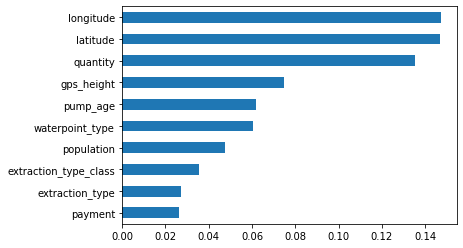

In [47]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances,index=features).sort_values().tail(10).plot(kind='barh')

# Check Metrics

**Accuracy Score**

In [48]:
print('Training Accuracy:', model.score(X_train,y_train))
print('Validation Accuracy:', model.score(X_val,y_val))

Training Accuracy: 0.993870840457714
Validation Accuracy: 0.8099747474747475


**Confusion Matrix**

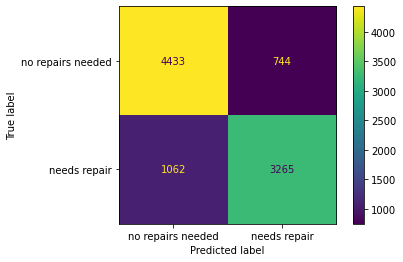

In [55]:
plot_confusion_matrix(model, X_val,y_val,values_format = '.0f', display_labels=['no repairs needed','needs repair']);

In [58]:
# Total 10,000 emails
# Class 0 - not spam - 9900
# Class 0 - spam - 100
100/10000
# Assume all 100 are misclassified as 0
9900/10000

0.99

**Precision Score**

Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [61]:
# precision = tp / (tp + fp)
3265/(3265+744)

0.8144175604889

**Recall Score** 

Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [60]:
# recall = tp/(tp + fn)
3265/(3265+1038)

0.7587729491052754

**Classification Report**

In [63]:
print(classification_report(y_val,model.predict(X_val),target_names=['no repair needed','needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.81      0.86      0.83      5177
    needs repair       0.81      0.75      0.78      4327

        accuracy                           0.81      9504
       macro avg       0.81      0.81      0.81      9504
    weighted avg       0.81      0.81      0.81      9504



In [ ]:
# F1-score = 2 * (precision*recall)/ (precision+recall)

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [64]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [65]:
y_val.value_counts(normalize=True)

0    0.544718
1    0.455282
Name: needs_repair, dtype: float64

In [70]:
repair_prob = y_val.value_counts(normalize=True).min()

print('Inspections conducted:',n_inspections)
print('Pumps repaired:',int(repair_prob*n_inspections) )
print('Funds wasted:', (n_inspections - repair_prob*n_inspections)*100)

Inspections conducted: 2000
Pumps repaired: 910
Funds wasted: 108943.60269360268


Scenario 2: Using our model "out of the box"

In [81]:
data={'y_val':y_val,
      'y_pred':model.predict(X_val)}

results = pd.DataFrame(data)

mask=(results['y_pred']==1)
sample = results[mask].sample(n_inspections)

print('Inspections conducted:',n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample['y_val'].sum())*100)

Inspections conducted: 2000
Pumps repaired: 1640
Funds wasted: 36000


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.

In [86]:
data={'y_val':y_val,'y_pred_proba':model.predict_proba(X_val)[:,-1]}
results = pd.DataFrame(data)

threshold= 0.85

mask=(results['y_pred_proba']>threshold)
sample = results[mask].sample(n_inspections)

print('Inspections conducted:',n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample['y_val'].sum())*100)

Inspections conducted: 2000
Pumps repaired: 1903
Funds wasted: 9700


# ROC Curve - Will be covered in the next module.

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

This curve plots two parameters: True Positive Rate. False Positive Rate.


In [ ]:
# True positive rate vs false positive rate